In [28]:
import numpy as np
from pyL5.lib.analysis.container import Container
from skimage import data, io, feature, filters
import matplotlib.pyplot as plt
import dask.array as da
from scipy import optimize, interpolate
import scipy.ndimage as ndi
import time


# Functions for data correction

In [2]:
def Import(filepath):
    """Returns the container and the nlp file as a dask array"""
    cont = Container(filepath)
    return (cont.getStack().getDaskArray(), cont)
    
def FilterImageGaussian(im, sig):
    return filters.gaussian(im,sigma = sig)

def Labels(a,b, figure,plot):
    figure.gca().set_aspect('equal')
    #clb = plot.colorbar()
    if a == 1:
        plot.set_xlabel('Pixel X')
        plot.set_ylabel('Pixel Y')
    if a == 2:
        plot.set_xlabel('Deflection x (milli-ampere)')
        plot.set_ylabel('Deflection y (milli-ampere)')
    #if b == 1:
    #    clb.label('Intensity')
    #if b == 2:
    #    clb.label('Image Number')
    
def PlotImage(data, imagenumber):
    """Makes a plot of the given image from the data set.
    
Parameters
----------
data: Needs to be a dask array
imagenumber: needs to be an integer in range(data.shape[0])
    
    """
    im = data[imagenumber].compute()
    plt.imshow(im.T, vmax = im.mean()*3) #x and y axis are switched in the image. Also there are a few points with
                                         #very high intensity. Thus implementing vmax like this shows more.


def MaximaPeaks(data):
    """Returns position of maxima in each image as np array"""
    maxima = da.argmax(data.reshape((data.shape[0],-1)), axis=1).compute() #da.argmax only works on lower dimensional arrays, therefore reshape
    maxima = np.unravel_index(maxima, data.shape[1:])
    return np.stack(maxima)

def PlotPositions(positions):
    """Makes a scatter plot of all the positions"""
    plt.scatter(*positions, c=np.arange(positions.shape[1]))

def DeflectorValues(container):
    """Returns the deflector values as an np array"""
    return np.stack((100*np.array(container['DEFL1Y']),100*np.array(container['DEFL1X']))) #times 100 so that the difference is more visible
    
def SubsetFromCenter(positions, radius):
    """Returns boolean for the indices"""
    center = np.mean(positions, axis=1, keepdims=True)
    center_indices = np.linalg.norm(np.abs(positions-center), axis=0) < radius
    return center_indices
    
def PlotSubset(positions, subset):
    """Makes a plot with the np array given and marks the subset of this array given"""
    plt.scatter(*positions, c=np.arange(positions.shape[1]))
    plt.scatter(*positions[:, subset], c='red', marker='x')

def transformation_error(A,B,C):
    """Function used to optimize the first order transformation matrix"""
    A = A.reshape((2,-1))
    return np.sum((np.linalg.norm(np.matmul(A,B) - C, axis = 0))**2)
    
def LinearCorrection(positions1, positions2, subset):
    """Calculates the most optimal linear transformation from positions1 to positions2 centered around their mean"""
    P1 = positions1[:, subset]
    P2 = positions2[:,subset]
    P1M = P1.mean(axis=1, keepdims=True) #0th order correction
    P2M = P2.mean(axis=1, keepdims=True)
    P1 = P1-P1M #For the first order correction the zeroeth order needs to be taken off
    P2 = P2-P2M
    G = np.array([1,0,0,-1]) #Guess for optimization
    res = optimize.minimize(transformation_error,G, args = (P1,P2))
    Tmatrix = res.x.reshape((2,-1))
    print('First order tranformation matrix:', Tmatrix)
    print('Error: ' + str(res.fun))
    print(res.message)
    return Tmatrix

def LatticePointPositions(positions1, positions2, subset):
    """Uses the LinearCorrection function to find and apply the transformation"""
    Tmatrix = LinearCorrection(positions1, positions2, subset)
    P1 = positions1[:, subset]
    P2 = positions2[:,subset]
    P1M = P1.mean(axis=1, keepdims=True)
    P2M = P2.mean(axis=1, keepdims=True)
    positions1centered = positions1 - P1M
    firstorder = np.matmul(Tmatrix, positions1centered)
    linearcorrection = firstorder + P2M
    return linearcorrection, Tmatrix, P1M, P2M
    
def DataCuts(data, positions, radius):
    """Returns cuts of data as squares centered around the positions given. Also returns the position of the top left corener in relation to the entire data"""
    #Initialize
    Error = np.full((2,data.shape[0]), 0)
    Datacuts = np.full((data.shape[0], 2*radius+1, 2*radius+1), np.nan)
    for i in range(data.shape[0]):
        Error[:,[i]] = positions[:,[i]] - radius
        Datacuts[i, -np.min((Error[0,i],0)):, -np.min((Error[1,i],0)):] =  data[i,np.max((Error[0,i],0)):np.max((Error[0,i],0))+2*radius+1, np.max((Error[1,i],0)):np.max((Error[1,i],0))+2*radius+1]
    return (Datacuts,Error)

def NearestPeaks(data, positions, radius):
    """Looks for the maxima peak in a square with the specified 'radius' at the positions"""
    Datacuts, Error = DataCuts(data, positions, radius)
    #Initialize
    maxcoords = np.full((2,data.shape[0]), 0.)
    for i in range(data.shape[0]):
        vecmaxcoord = np.unravel_index(np.argmax(Datacuts[i]), Datacuts[i].shape) #Position of the maximum in the datacut
        maxcoords[:,i] = vecmaxcoord + Error[:,i] #Position of the maximum in the data
    return maxcoords    

def NearestPeaksWithInfo(data, positions, radius):
    """The Nearest Peaks function but with extra info about error, intensities and distances"""
    Datacuts, Error = DataCuts(data, positions, radius)
    #Initialize
    Intensities = np.full(data.shape[0], 0.)
    Distances = np.full(data.shape[0], 0.)
    maxcoords = np.full((2,data.shape[0]), 0.)
    ErrorFromPos = np.full((2,data.shape[0]), 0.)
    for i in range(data.shape[0]):
        vecmaxcoord = np.unravel_index(np.argmax(Datacuts[i]), Datacuts[i].shape) #Position of the maximum in the datacut
        Intensities[i] = Datacuts[i][vecmaxcoord] #Intensity of the maximum
        maxcoords[:,i] = vecmaxcoord + Error[:,i] #Position of the maximum in the data
        ErrorFromPos[:,i] = maxcoords[:,i] -positions[:,i]
        Distances[i] = np.linalg.norm(ErrorFromPos[:,i])
    return (maxcoords, ErrorFromPos, Distances, Intensities)

def PlotQuiverError(positions, ErrorFromPositions):
    """Returns a quiver plot of the positions with vectors of the errors"""
    plt.quiver(*positions, *ErrorFromPositions, np.arange(data.shape[0]))
    
def CalculateSplineInterpolation(positions1, positions2):
    """Returns the calculated spline interpolation for positions1 to positions2"""
    xspline = interpolate.SmoothBivariateSpline(*positions1, positions2[0]) #Spline intepolation needs to be done on both axis seperately 
    yspline = interpolate.SmoothBivariateSpline(*positions1, positions2[1])
    return (xspline,yspline)

def ApplySplineInterpolation(xspline, yspline, positions):
    """Uses the given spline interpolation and then applies it to positions"""
    xposspline = interpolate.SmoothBivariateSpline.ev(xspline, *positions)
    yposspline = interpolate.SmoothBivariateSpline.ev(yspline, *positions)
    return np.vstack((xposspline,yposspline))

def MakeCoordinates(function, pixelsx, pixelsy): #mistake?
    """Returns the coordinates at which each pixel is evaluated by the function. Used for the mapcoordinates function."""
    xx, yy = np.meshgrid(np.arange(pixelsx), np.arange(pixelsy), indexing = 'ij')
    return function(np.stack([xx,yy]).reshape(2,-1)).reshape((2, pixelsx, pixelsy))

def CorrectImage(function, image): #mistake?
    """Returns the corrected image using the function that goes from corrected image to image"""
    coordinates = MakeCoordinates(function, image.shape[0], image.shape[1])
    CorrectedImage = ndi.map_coordinates(image,coordinates)
    return CorrectedImage

def SaveCorrectedImageDataset(data, function, filename):
    """Corrects all the images in the data and saves it as the filename.npy. The Images are corrected just like in the CorrectImage function. All images in the dataset must have the same resolution"""
    filename = filename +'.npy'
    file = open(filename, "w")
    coordinates = MakeCoordinates(function, data.shape[1], data.shape[2])
    #Initialize
    CorrectedImages = np.full(data.shape, 0.)
    for i in range(data.shape[0]):
        Image = data[i].compute()
        CorrectedImage = ndi.map_coordinates(Image,coordinates)
        CorrectedImages[i] = CorrectedImage
    np.save(filename, CorrectedImages)
    file.close()

def GetDeflectorAndMaximaPeaks(filepath):
    """Returns Deflector and MaximaPeaks from nlp file"""
    data, container = Import(filepath)
    Maximapeaks = MaximaPeaks(data)
    Deflector = DeflectorValues(cont)
    return(Deflector, MaximaPeaks)
    
def Determiningr1(Deflector, MaximaPeaks, r1):
    """Shows what subset will be taken when using the value of r1. You want a value of r1 that contains as many points as possible and where the transformation is very linear. Use GetDeflectorAndMaximaPeaks for Deflector and MaximaPeaks."""
    center = SubsetFromCenter(Deflector, r1)
    plot1 = plt.figure(1)
    PlotSubset(Deflector, center)
    plot2 = plt.figure(2)
    PlotSubset(MaximaPeaks, center)
    plt.show()
    
def CorrectDataset(filepath, filename, r1, r2):
    """Corrects the images on the nlp file given by the filepath. The corrected images are saved to filename.npy. Use Determiningr1 function to help determine r1."""
    print('Importing data and container from nlp file...')
    data, container = Import(filepath)
    print('Determining maxima peaks in data...')
    Maximapeaks = MaximaPeaks(data)
    print('Making deflector value grid...')
    Deflector = DeflectorValues(cont)
    print('Taking subset from center using r1...')
    Center = SubsetFromCenter(Current, r1)
    print('Determining positions of the lattice point...')
    Latticepointpositions, matrix, curcent, maxcent = LatticePointPositions(Current, Maxima, Center)
    print('Determining camera positions of the lattice point using r2...')
    CameraPositions, Error, dist, intensities = NearestPeaksWithInfo(data, Latticepointpositions, r2)
    print('Calculating spline interpolation using positions of the lattice point to its error...')
    spline = CalculateSplineInterpolation(Deflector, Error)
    print('Defining error function...')
    def Error(Correct): #mistake?
        Correctcent = Correct - maxcent
        CorrectCurrentcent = np.matmul(np.linalg.inv(matrix), Correctcent)
        CorrectCurrent = CorrectCurrentcent + curcent
        return Correct + ApplySplineInterpolation(*spline, Correct)
    print('Correcting images...')
    SaveCorrectedImageDataset(data, Error, filename)
    print('Corrected images saved as ' + filename +'.npy, use np.load(\'' + filename + '.npy\')')

# Functions for Metric

In [3]:
def NumberOfPeaks(data, sig = 2):
    """Find the amount of peaks detected in each image
    
Parameters
----------
data: Can be a numpy or dask array
sig: The sigma used for the gaussian smooth over the images. Defaults to 2 if no value is given

Returns
----------
numberOfPeaks: A 1 dimensional numpy array
    """
    #Converts dask array to numpy array
    if type(data) != np.ndarray:
        tempdata = np.full(data.shape, 0.)
        tempdata[:] = data[:].compute()
        data = tempdata
    #Initialize
    numberOfPeaks = np.full(data.shape[0], 0)
    for i in range(data.shape[0]):
        tempGaussian = filters.gaussian(data[i],sigma = sig)
        TempMaximaCoordinate = feature.peak_local_max(tempGaussian, 50, threshold_abs = tempGaussian.mean()*3)
        numberOfPeaks[i] = TempMaximaCoordinate.shape[0]
    return numberOfPeaks
    
def DetectingPeaks(data, maxLatticePoints = -1, sig = 2):
    """Detects the peaks in each image.
    
Parameters
----------
data: Can be a numpy or dask array
maxLatticePoints: The maximum number of lattice points that can be found in each image. If no value is given it will calculate this.
sig: The sigma used for the gaussian smooth over the images. Defaults to 2 if no value is given

Returns
----------
MaximaCoordiantes: A numpy array with shape (number of images, 2, maxLatticePoints) displaying the coordinates of the peaks found in each image
    """
    #Converts dask array to numpy array
    if type(data) != np.ndarray:
        tempdata = np.full(data.shape, 0.)
        tempdata[:] = data[:].compute()
        data = tempdata
    if maxLatticePoints == -1:
        maxLatticePoints = np.max(NumberOfPeaks(data, sig))
        print('Maximum number of lattice points per image is ' + str(maxLatticePoints))
    #Initialize
    MaximaCoordinates = np.full((data.shape[0], 2, maxLatticePoints), np.nan)
    for i in range(data.shape[0]):
        tempGaussian = filters.gaussian(data[i],sigma = sig) #Gaussian smooth over image as sometimes weird inconsistencies were detected
        TempMaximaCoordinate = feature.peak_local_max(tempGaussian, 50, threshold_abs = tempGaussian.mean()*3)
        #If there is no peaks found we fill it with np.nan
        if TempMaximaCoordinate.shape == (0,2): 
            TempMaximaCoordinate = np.full((maxLatticePoints, 2), np.nan)
            print('picture number ' +str(i) + ' is an outlier')
        TempMaximaCoordinate = np.stack(TempMaximaCoordinate, axis = 1)
        MaximaCoordinates[i,:,:TempMaximaCoordinate.shape[1]] = TempMaximaCoordinate
    return MaximaCoordinates

def PeakDifferences(peaks, numberOfPeaks, TopLimit = -1):
    """Calcualtes the difference between each of the peaks.
    
Parameters
----------
peaks: A numpy array of shape (number of images, 2, max peaks per image). Gives the positions of all the peaks per image in the data set.
numberOfPeaks: A 1 dimensional array with length the number of images. Gives the amount of peaks in each image
TopLimit: Integer. The maximum number of differences.

Returns
----------
peakDifferences: A numpy array with shape (2, TopLimit) giving the vectors of all the differences.
    """
    TopLimitNotGiven = False
    MaxPeaks = np.max(numberOfPeaks)
    if (TopLimit == -1):
        TopLimit = (MaxPeaks**2)*numberOfPeaks.shape[0]
        TopLimitNotGiven = True
    #Initialize
    peakDifferences = np.full((2,TopLimit), np.nan)
    j = 0
    for i in range(numberOfPeaks.shape[0]):
        for l1 in range(numberOfPeaks[i]):
            for l2 in [x for x in range(numberOfPeaks[i]) if x != l1]:
                peakDifferences[:,j] = peaks[i,:,l1] - peaks[i,:,l2]
                j = j+1
    if TopLimitNotGiven:
        print("TopLimit is " + str(j))
    return peakDifferences

def Lattice(peakDifferences, radius):
    AveragePeakDifference = np.full(peakDifferences.shape, np.nan)
    NumberInAverage = np.full(peakDifferences.shape[1], np.nan)
    for i in range(0,peakDifferences.shape[1]):
        TempIndices = np.linalg.norm(peakDifferences[:,i].reshape(2,1)-peakDifferences, axis = 0) < radius
        NumberInAverage[i] = sum(TempIndices)
        TempAverage = np.mean(peakDifferences[:,TempIndices], axis = 1)
        AveragePeakDifference[:,i] = TempAverage
    Max = np.max(NumberInAverage[np.isfinite(NumberInAverage)])
    APDIndices = NumberInAverage > Max - Max/2
    AveragePeakDifferenceRemovePercent = AveragePeakDifference[:,APDIndices]
    AveragePeakDifferenceTemporary = np.full(AveragePeakDifferenceRemovePercent.shape, np.nan)
    for i in range(AveragePeakDifferenceTemporary.shape[1]):
        TempIndices = np.linalg.norm(AveragePeakDifferenceRemovePercent[:,i].reshape(2,1)-AveragePeakDifferenceRemovePercent, axis = 0) < radius
        TempAverage = np.mean(AveragePeakDifferenceRemovePercent[:,TempIndices], axis = 1)
        AveragePeakDifferenceTemporary[:,i] = TempAverage
    Lattice = np.unique(AveragePeakDifferenceTemporary, axis = 1)
    return Lattice

def MVariance(Lattice, peakDifferences, radius):
    variance = np.full((Lattice.shape[1],2), np.nan)
    for i in range(Lattice.shape[1]):
        tempIndices = np.linalg.norm(Lattice[:,i].reshape(2,1)-peakDifferences[:], axis = 0) < 2*radius
        variance[i] = np.var(peakDifferences[:,tempIndices], axis = 1)/peakDifferences[:,tempIndices].shape[1]
    return variance
    
def MDistance(Lattice):
    distance = np.full(Lattice.shape[1], np.nan)
    for i in range(Lattice.shape[1]):
        distance[i] = np.linalg.norm(Lattice[:,i])
    return distance

def MAngles(Lattice):
    Angles = np.full((Lattice.shape[1],Lattice.shape[1]), np.nan)
    for j in range(Lattice.shape[1]):
        for k in range(Lattice.shape[1]):
            if (j != k):
                tempcosangle = np.matmul(Lattice[:,j], Lattice[:,k])/(np.linalg.norm(Lattice[:,j]) *np.linalg.norm(Lattice[:,k]))
                tempangle = np.arccos(tempcosangle)
                Angles[j,k] = np.degrees(tempangle)
    return Angles

def Metric(Lattice, peakDifferences, radius):
    MetricVar =  np.sum(MVariance(Lattice, peakDifferences, radius), axis = 0)
    print('The variance around each lattice point sums to:', MetricVar)
    MetricDist = np.var(MDistance(Lattice))
    print('The variance in distance from the center to a lattice point is:', MetricDist)
    Angles = MAngles(Lattice)
    AnglesMod = Angles[np.isfinite(Angles)]%60
    AnglesMod[AnglesMod > 30] = AnglesMod[AnglesMod > 30] - 60
    MetricAngles = np.var(AnglesMod)
    print('The variance of each angle between two lattice points modulo 60 and with respect to the center is:', MetricAngles)
    return (MetricVar, MetricDist, MetricAngles)

def doMetric(data, radius, toplim = -1):
    print("Calculating number of peaks...")
    npeaks = NumberOfPeaks(data)
    print("Calculating peak positions...")
    peaks = DetectingPeaks(data, np.max(npeaks))
    print("Calculating peak difference vectors...")
    peakDifferences = PeakDifferences(peaks, npeaks, toplim)
    print("Calculating average cluster positions...")
    lattice = Lattice(peakDifferences, radius)
    print("Executing metric...")
    var, dist, angles = Metric(lattice, peakDifferences, radius)
    return peakDifferences, lattice, var, dist, angles

# Trying it out

C:\Users\lkiel\Documents\BRP\20200213_143520_Diff_538.2_sweep-DEFL1X-DEFL1Y.nlp
int64


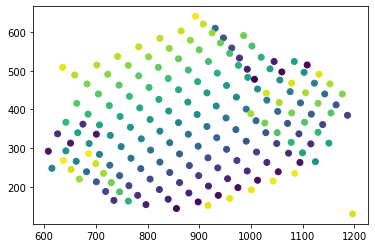

In [25]:
data, cont = Import(r'C:\Users\lkiel\Documents\BRP\20200213_143520_Diff_538.2_sweep-DEFL1X-DEFL1Y.nlp')
Maxima = MaximaPeaks(data)
PlotPositions(Maxima)
PlotPositions
print(Maxima.dtype)

In [26]:
data.shape

(182, 1280, 1024)

In [5]:
radius = 0.2
Current = DeflectorValues(cont)
Center = SubsetFromCenter(Current, radius)
Latticepointpositions, matrix, curcent, maxcent = LatticePointPositions(Current, Maxima, Center)
CameraPositions, Error, dist, intensities = NearestPeaksWithInfo(data, Latticepointpositions, 50)

First order tranformation matrix: [[ 524.99999244 -271.65715086]
 [ 311.36363109  433.60000849]]
Error: 57.956783216843924
Optimization terminated successfully.


# Subset Analysis

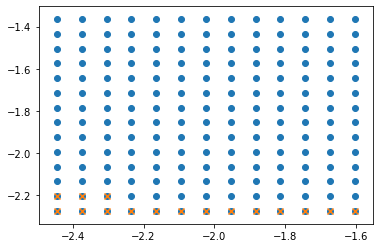

In [10]:
plt.scatter(*Current)
plt.scatter(*Current[:,0:16], marker = 'x')

In [11]:
index = np.arange(0,13*14)
print(index)
index = index.reshape(14,13)
print(index)
index = np.flip(index, axis = 0)
print(index)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
[[  0   1   2   3   4   5   6   7   8   9  10  11  12]
 [ 13  14  15  16  17  18  19  20  21  22  23  24  25]
 [ 26  27  28  29  30  31  32  33  34  35  36  37  38]
 [ 39  40  41  42  43  44  45  46  47  48  49  50  51]
 [ 52  53  54  55  56  57  58  59  60  6

In [12]:
#Subset where only the 2nd row and columns are kept
index2ndrow = np.delete(index, list(range(1, index.shape[0], 2)), axis=0)
index2ndcolrow = np.delete(index2ndrow, list(range(0, index2ndrow.shape[1], 2)), axis=1).flatten()


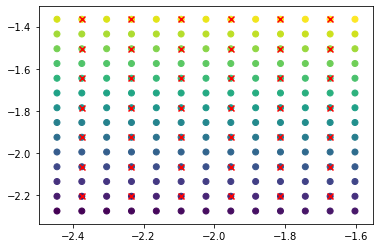

In [13]:
PlotSubset(Current, index2ndcolrow)

In [14]:
#Block of 25% from the middle
centercur = np.mean(Current, axis = 1)
indexmid = np.linalg.norm(Current-centercur.reshape(2,1), axis = 0) < 0.27
print(Current[:,indexmid].shape)

(2, 44)


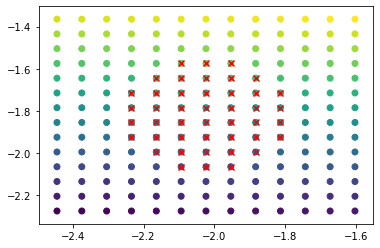

In [15]:
PlotSubset(Current, indexmid)

In [16]:
#25% of the peaks with the most intensity
indexintensities = np.argpartition(intensities, -46)[-46:]

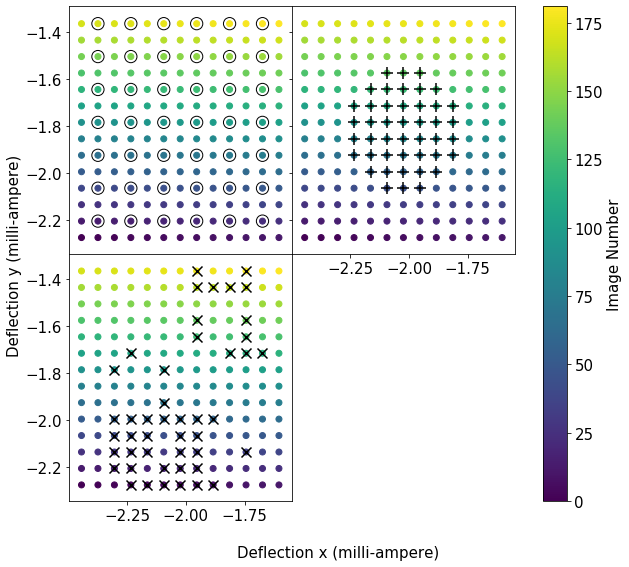

In [130]:
plt.rc('font', size= 15) 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols =2, figsize =(10,9.1), sharey = 'all', sharex = 'col', gridspec_kw={'hspace': 0, 'wspace': 0})


ax1.scatter(*Current, c =  np.arange(data.shape[0]))
ax1.scatter(*Current[:,index2ndcolrow], s=150, facecolors='none', edgecolors='black')
ax1.set_aspect('equal')

ax2.scatter(*Current, c =  np.arange(data.shape[0]))
ax2.scatter(*Current[:,indexmid], c ='black', marker = '+', s = 150)
ax2.set_aspect('equal')
ax2.tick_params(
    axis='x',           # changes apply to the x-axis
    which='both',       # both major and minor ticks are affected
    bottom=True,
    top=False,
    labelbottom=True)

sc = ax3.scatter(*Current, c =  np.arange(data.shape[0]))
ax3.scatter(*Current[:,indexintensities], c ='black', marker = 'x', s = 100)
ax3.set_aspect('equal')


ax4.set_aspect('equal')
ax4.axis('off')

clb = plt.colorbar(sc, ax=((ax1, ax2), (ax3, ax4)))
clb.set_label('Image Number')

fig.text(0.5, 0.04, 'Deflection x (milli-ampere)', ha='center')
fig.text(0.04, 0.5, 'Deflection y (milli-ampere)', va='center', rotation='vertical')

plt.savefig('SubsetsAll.pdf')

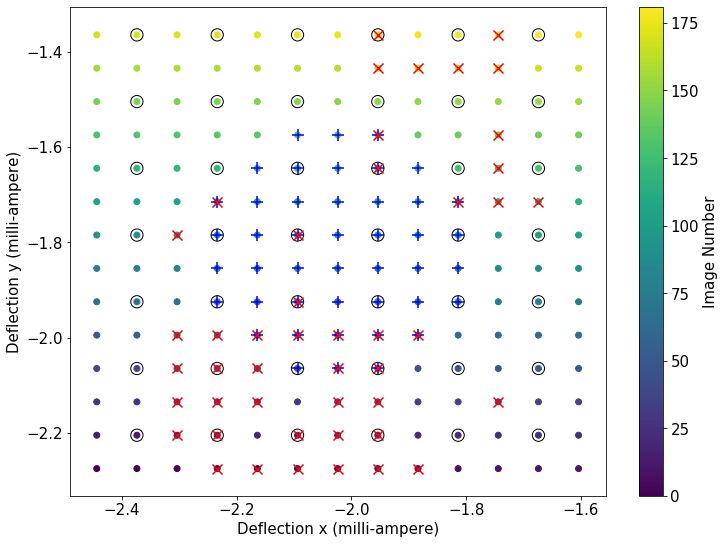

In [57]:
plt.rc('font', size= 15) 
plt.figure(figsize=[12,9])
plt.scatter(*Current, c =  np.arange(data.shape[0]))
clb = plt.colorbar()
clb.set_label('Image Number')
plt.scatter(*Current[:,index2ndcolrow], s=150, facecolors='none', edgecolors='black')
plt.scatter(*Current[:,indexmid], c ='b', marker = '+', s = 150)
plt.scatter(*Current[:,indexintensities], c ='r', marker = 'x', s = 100)
plt.xlabel('Deflection x (milli-ampere)')
plt.ylabel('Deflection y (milli-ampere)')

plt.savefig('subsets.pdf')


In [18]:
splinelattice = CalculateSplineInterpolation(Latticepointpositions, Error)
spline = CalculateSplineInterpolation(Current, Error)

spline2ndcolrow = CalculateSplineInterpolation(Current[:,index2ndcolrow], Error[:,index2ndcolrow])
splinemid = CalculateSplineInterpolation(Current[:,indexmid], Error[:,indexmid])
splineintensities = CalculateSplineInterpolation(Current[:,indexintensities], Error[:,indexintensities])
#spline = CalculateSplineInterpolation(Current[:,index], Error[:,index])

C:\Users\lkiel\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:1065: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)
C:\Users\lkiel\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:1065: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


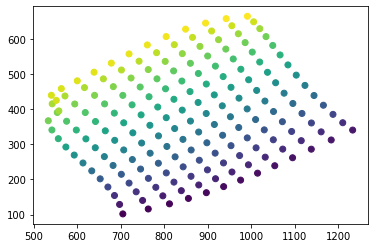

In [19]:
def CorrectedImageToImage(Correct):
    Correctcent = Correct - maxcent
    CorrectCurrentcent = np.matmul(np.linalg.inv(matrix), Correctcent)
    CorrectCurrent = CorrectCurrentcent + curcent
    return Correct + ApplySplineInterpolation(*spline, CorrectCurrent)
PlotPositions(CorrectedImageToImage(Latticepointpositions))

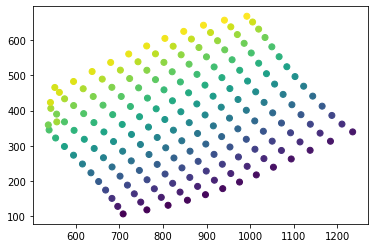

In [20]:
def CorrectedImageToImage2(Correct):
    return Correct + ApplySplineInterpolation(*splinelattice, Correct)
PlotPositions(CorrectedImageToImage2(Latticepointpositions))

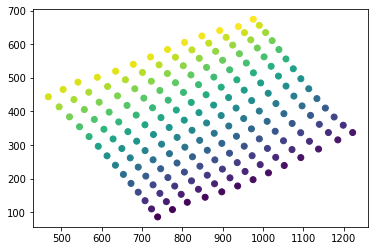

In [21]:
def CorrectedImageToImage2ndcolrow(Correct):
    Correctcent = Correct - maxcent
    CorrectCurrentcent = np.matmul(np.linalg.inv(matrix), Correctcent)
    CorrectCurrent = CorrectCurrentcent + curcent
    return Correct + ApplySplineInterpolation(*spline2ndcolrow, CorrectCurrent)

def CorrectedImageToImagemid(Correct):
    Correctcent = Correct - maxcent
    CorrectCurrentcent = np.matmul(np.linalg.inv(matrix), Correctcent)
    CorrectCurrent = CorrectCurrentcent + curcent
    return Correct + ApplySplineInterpolation(*splinemid, CorrectCurrent)

def CorrectedImageToImageintensities(Correct):
    Correctcent = Correct - maxcent
    CorrectCurrentcent = np.matmul(np.linalg.inv(matrix), Correctcent)
    CorrectCurrent = CorrectCurrentcent + curcent
    return Correct + ApplySplineInterpolation(*splineintensities, CorrectCurrent)
PlotPositions(CorrectedImageToImageintensities(Latticepointpositions))

In [22]:
Image = data[0].compute()


In [118]:
correctimagelat = CorrectImage(CorrectedImageToImage2, Image)
correctimagecur = CorrectImage(CorrectedImageToImage, Image)

correctimage2ndcolrow = CorrectImage(CorrectedImageToImage2ndcolrow, Image)


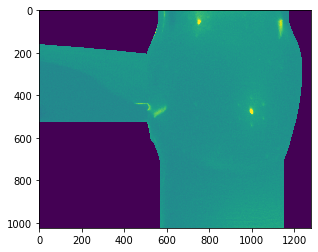

In [119]:
plt.imshow(correctimage1.T, vmax = correctimage1.mean()*3)

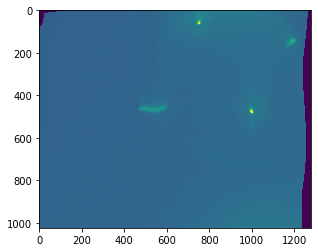

In [120]:
plt.imshow(correctimage2.T, vmax = correctimage2.mean()*3)

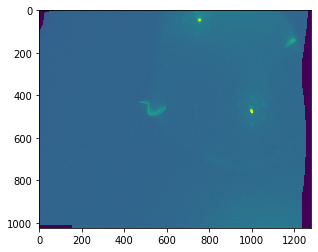

In [121]:
plt.imshow(correctimage2ndcolrow.T, vmax = correctimage2.mean()*3)

In [29]:

start = time.time()
CorrectDataset(r'C:\Users\lkiel\Documents\BRP\20200213_143520_Diff_538.2_sweep-DEFL1X-DEFL1Y.nlp', "correctedtest", 0.2, 50)
end = time.time()
print(end - start)
#correctedimagesintensities = np.load("correctedintensities.npy")

Importing data and container from nlp file...
C:\Users\lkiel\Documents\BRP\20200213_143520_Diff_538.2_sweep-DEFL1X-DEFL1Y.nlp
Determining maxima peaks in data...
Making deflector value grid...
Taking subset from center using r1...
Determining positions of the lattice point...
First order tranformation matrix: [[ 524.99999244 -271.65715086]
 [ 311.36363109  433.60000849]]
Error: 57.956783216843924
Optimization terminated successfully.
Determining camera positions of the lattice point using r2...
Calculating spline interpolation using positions of the lattice point to its error...
Defining error function...
Correcting images...


C:\Users\lkiel\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:1065: UserWarning: 
No more knots can be added because the additional knot would (quasi)
coincide with an old one: s too small or too large a weight to an
inaccurate data point.
The weighted least-squares spline corresponds to the current set of
knots.
  warnings.warn(message)


Corrected images saved as correctedtest.npy, use np.load('correctedtest.npy')
50.905269384384155


In [83]:
correctedimagescurrent = np.load("correctedimages.npy")
correctedimageslattice = np.load("CorrectedImagesSplineFromLttice.npy")
correctedimages2ndcolrow = np.load("corrected2ndcolrowcorrect.npy")
correctedimagesmid = np.load("correctedmid.npy")
correctedimagesintensities = np.load("correctedintensities.npy")

rad = 100

In [84]:
pdiffcurrent, latcurrent, varcurrent, distcurrent, anglescurrent = doMetric(correctedimagescurrent, rad)
pdifflattice, latlattice, varlattice, distlattice, angleslattice = doMetric(correctedimageslattice, rad)
pdiff2ndcolrow, lat2ndcolrow, var2ndcolrow, dist2ndcolrow, angles2ndcolrow = doMetric(correctedimages2ndcolrow, rad)
#pdiff, lat, var, dist, angles = doMetric(correctedimages, rad)

Calculating number of peaks...
Calculating peak positions...
picture number 143 is an outlier
picture number 156 is an outlier
picture number 157 is an outlier
Calculating peak difference vectors...
TopLimit is 640
Calculating average cluster positions...


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less
C:\Users\lkiel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lkiel\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Executing metric...
The variance around each lattice point sums to: [ 9.94285059 32.03591144]
The variance in distance from the center to a lattice point is: 195.76243942161008
The variance of each angle between two lattice points modulo 60 and with respect to the center is: 5.528226542527003
Calculating number of peaks...


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in less


Calculating peak positions...
Calculating peak difference vectors...
TopLimit is 3454
Calculating average cluster positions...
Executing metric...
The variance around each lattice point sums to: [9881.26291718 8225.18309109]
The variance in distance from the center to a lattice point is: 41641.641914583284


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in arccos


The variance of each angle between two lattice points modulo 60 and with respect to the center is: 298.7906126816652
Calculating number of peaks...
Calculating peak positions...
picture number 143 is an outlier
picture number 156 is an outlier
picture number 157 is an outlier
Calculating peak difference vectors...
TopLimit is 626
Calculating average cluster positions...
Executing metric...
The variance around each lattice point sums to: [10.10897482 30.07451371]
The variance in distance from the center to a lattice point is: 388.3028621963011
The variance of each angle between two lattice points modulo 60 and with respect to the center is: 13.70292722219173


In [98]:
pdiffdata, latdata, vardata, distdata, anglesdata = doMetric(data, rad)

Calculating number of peaks...
Calculating peak positions...
picture number 143 is an outlier
picture number 156 is an outlier
picture number 157 is an outlier
Calculating peak difference vectors...
TopLimit is 616
Calculating average cluster positions...


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less
C:\Users\lkiel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lkiel\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Executing metric...
The variance around each lattice point sums to: [ 9.55011582 20.67858003]
The variance in distance from the center to a lattice point is: 1761.8071561784939
The variance of each angle between two lattice points modulo 60 and with respect to the center is: 64.11330016141508


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in less


In [85]:
pdiffmid, latmid, varmid, distmid, anglesmid = doMetric(correctedimagesmid, rad)

Calculating number of peaks...
Calculating peak positions...
picture number 143 is an outlier
picture number 156 is an outlier
picture number 157 is an outlier
Calculating peak difference vectors...
TopLimit is 628
Calculating average cluster positions...


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less


Executing metric...
The variance around each lattice point sums to: [ 9.61797895 23.60837286]
The variance in distance from the center to a lattice point is: 1258.9550125267729
The variance of each angle between two lattice points modulo 60 and with respect to the center is: 45.91212712997107


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in less


In [86]:
pdiffintensities, latintensities, varintensities, distintensities, anglesintensities = doMetric(correctedimagesintensities, rad)

Calculating number of peaks...
Calculating peak positions...
picture number 143 is an outlier
picture number 156 is an outlier
picture number 157 is an outlier
Calculating peak difference vectors...
TopLimit is 646
Calculating average cluster positions...


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in less


Executing metric...
The variance around each lattice point sums to: [10.087006   24.20182718]
The variance in distance from the center to a lattice point is: 403.7706746546822
The variance of each angle between two lattice points modulo 60 and with respect to the center is: 14.972728392581173


C:\Users\lkiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in less


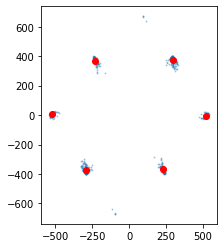

In [29]:
plt.scatter(*pdiffmid, alpha=0.3, s=1)
#plt.scatter(*latmid,  c =  'red', marker = 'x')
plt.scatter(*latmid, c = 'r')
plt.gca().set_aspect('equal')

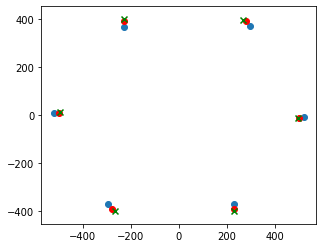

In [87]:
plt.scatter(*latmid)
plt.scatter(*lat2ndcolrow, c = 'r')
plt.scatter(*latcurrent, c = 'g', marker = 'x')
plt.gca().set_aspect('equal')

In [100]:
print('Variance in clusters (xy) |', 'Variance in distances |', 'Variance in angles |', 'subset')
print(vardata, distdata, anglesdata, '-Uncorrected')
print(varcurrent, distcurrent, anglescurrent, '-All the data')
print(var2ndcolrow, dist2ndcolrow, angles2ndcolrow, '-Every second column and row deleted')
print(varmid, distmid, anglesmid, '-25% from the middle')
print(varintensities, distintensities, anglesintensities, '-25% of highest intensity points')

Variance in clusters (xy) | Variance in distances | Variance in angles | subset
[ 9.55011582 20.67858003] 1761.8071561784939 64.11330016141508 -Uncorrected
[ 9.94285059 32.03591144] 195.76243942161008 5.528226542527003 -All the data
[10.10897482 30.07451371] 388.3028621963011 13.70292722219173 -Every second column and row deleted
[ 9.61797895 23.60837286] 1258.9550125267729 45.91212712997107 -25% from the middle
[10.087006   24.20182718] 403.7706746546822 14.972728392581173 -25% of highest intensity points
